<a href="https://colab.research.google.com/github/MasterBeard/Image-Augmentation/blob/main/Smart_Ship_Brute_Force_Data_Test_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# 文件路径
file_path = '/content/drive/My Drive/df_final_red_sum_abs.csv'

# 读取数据，排除指定的列
df = pd.read_csv(file_path, usecols=lambda column: not column.startswith('Unnamed'))

In [3]:
import pandas as pd

# Assume df has already been read
df_filtered = df[['Transfers Date', 'Transfers : Time Question', 'Transfers : Turbine', 'Lat', 'Lon', 'distance', 'Total fuel used L']].copy()

# Ensure the time format is correct
df_filtered['Transfers : Time Question'] = pd.to_datetime(df_filtered['Transfers : Time Question'], format='%H:%M:%S')

speed_per_date = []

for date, group_1 in df_filtered.groupby('Transfers Date'):
    # Count the occurrences of each turbine
    turbine_counts = group_1['Transfers : Turbine'].value_counts()

    # Process only if all turbines appear at least twice
    if all(turbine_counts == 2):
        # Sort by time
        group = group_1.sort_values('Transfers : Time Question').reset_index(drop=True)

        # Ensure there is enough data for splitting
        mid_idx = len(group) // 2
        if len(group) > 1 and mid_idx > 0:
            # Split the first half (in normal order)
            upper_part = group.iloc[:mid_idx].reset_index(drop=True)

            # Split the second half (reverse order and reset index)
            lower_part = group.iloc[-mid_idx:].iloc[::-1].reset_index(drop=True)

            # Keep only matching 'Transfers : Turbine' for pairing
            merged = upper_part.merge(lower_part, on='Transfers : Turbine', suffixes=('_upper', '_lower'))

            # Calculate the time difference
            merged['time_diffs'] = (merged['Transfers : Time Question_upper'] - merged['Transfers : Time Question_lower']).dt.total_seconds() / 3600

            # Calculate the total travel distance
            total_distance = group['distance'].sum()

            # Store the results
            for _, row in merged.iterrows():
                speed_per_date.append({
                    'Date': date,
                    'Turbine': row['Transfers : Turbine'],
                    'Time Difference (hours)': row['time_diffs'],
                    'Distance': total_distance,
                    'Lat': row['Lat_upper'],
                    'Lon': row['Lon_upper']
                })

# Convert to DataFrame
speed_df = pd.DataFrame(speed_per_date)

In [4]:
speed_df

,Date,Turbine,Time Difference (hours),Distance,Lat,Lon
0,01/12/2023,Lowestoft,-8.333333,77.493872,52.474199,1.736557
1,01/12/2023,EA1 F17,-4.666667,77.493872,52.261450,2.562450
2,01/12/2023,EA1 E17,-4.750000,77.493872,52.258217,2.531650
3,02/05/2022,Lowestoft,-11.583333,79.725538,52.474199,1.736557
4,02/05/2022,EA1 E12,-8.416667,79.725538,52.226533,2.549617
...,...,...,...,...,...,...
302,30/06/2024,Lowestoft,-9.083333,57.228709,52.474199,1.736557
303,30/06/2024,EA1 A10,-5.000000,57.228709,52.200183,2.436350
304,30/07/2024,Lowestoft,-10.250000,64.136947,52.474199,1.736557
305,30/07/2024,EA1 G26,-5.083333,64.136947,52.322883,2.561483


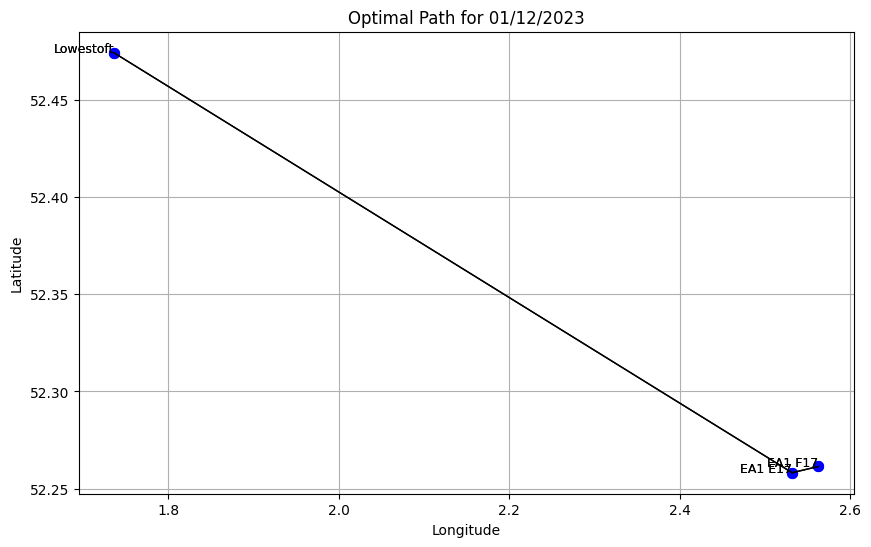

In [7]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from itertools import permutations

# Haversine function to calculate the distance between two geographic points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius (meters)
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance_meters = R * c
    return distance_meters / 1852  # Convert to nautical miles

# Sailing speed (nautical miles per hour)
sailing_speed = 11.96

# Process data for each date
optimal_routes = []

for date, group in speed_df.groupby('Date'):
    # Ensure there are enough data points
    if len(group) < 2:
        continue  # Skip if not enough nodes

    # Extract the starting point (first record) and other nodes
    start_point = group.iloc[0].to_dict()
    nodes_list = group.iloc[1:].to_dict('records')

    # Extract waiting times (absolute values to avoid negative waiting times)
    wait_times = {node['Turbine']: abs(node['Time Difference (hours)']) for node in nodes_list}

    # Generate all possible paths to find the shortest one
    permutations_list = permutations(nodes_list)
    min_distance = float('inf')
    best_route = None

    for perm in permutations_list:
        # Construct the travel route (visit all nodes and return)
        route = [start_point] + list(perm) + list(perm)[::-1] + [start_point]

        total_distance = 0
        total_wait_distance = 0
        remaining_wait_times = wait_times.copy()  # Copy initial waiting times
        visited_nodes = set()  # Track visited nodes

        half_point = len(route) // 2  # **Index for the halfway point**

        for i in range(len(route) - 1):
            node1, node2 = route[i], route[i + 1]
            node2_name = node2['Turbine']

            # Calculate travel distance
            distance = haversine(node1['Lat'], node1['Lon'], node2['Lat'], node2['Lon'])
            total_distance += distance

            # Calculate travel time
            travel_time = distance / sailing_speed

            # After the halfway point, consider remaining waiting times
            if i >= half_point and i != (len(route) - 2):
                extra_wait_time = max(remaining_wait_times[node2_name] - travel_time, 0)
                total_wait_distance += extra_wait_time   # Additional travel distance due to waiting time

            # Update remaining waiting times for all visited nodes
            for node in visited_nodes:
                remaining_wait_times[node] = max(0, remaining_wait_times[node] - travel_time)

            # Mark node2 as visited
            visited_nodes.add(node2_name)

        # Total travel cost (excluding waiting distance)
        total_travel_cost = total_distance

        # Select the optimal route
        if total_travel_cost < min_distance:
            min_distance = total_travel_cost
            best_route = [node['Turbine'] for node in route]  # Keep only Turbine names
            benchmark_distance = node1['Distance']
            benchmark_hour = route[0]['Time Difference (hours)']
            waithours = total_wait_distance
            expected_hour = total_travel_cost/sailing_speed + total_wait_distance
    # Store the optimal route information
    optimal_routes.append({
        'Date': date,
        'Best Route': best_route,
        'Waiting hours': waithours,
        'Total Travel Cost': min_distance,
        'Benchmark Distance': benchmark_distance,
        'Expected Hours': expected_hour,
        'Benchmark Hours': abs(benchmark_hour)
    })

# Convert to DataFrame and display
optimal_routes_df = pd.DataFrame(optimal_routes)

# Plot the optimal route (example for the first date)
if not optimal_routes_df.empty:
    best_route_example = optimal_routes_df.iloc[0]['Best Route']

    plt.figure(figsize=(10, 6))

    # Retrieve coordinate information
    lat_lon_map = {row['Turbine']: (row['Lat'], row['Lon']) for _, row in speed_df.iterrows()}

    # Plot nodes
    for turbine in best_route_example:
        lat, lon = lat_lon_map[turbine]
        plt.scatter(lon, lat, color='blue', marker='o', s=50)
        plt.text(lon, lat, turbine, fontsize=9, ha='right')

    # Plot travel path
    for i in range(len(best_route_example) - 1):
        lat1, lon1 = lat_lon_map[best_route_example[i]]
        lat2, lon2 = lat_lon_map[best_route_example[i + 1]]
        plt.plot([lon1, lon2], [lat1, lat2], 'k-', linewidth=1)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Optimal Path for {optimal_routes_df.iloc[0]["Date"]}')
    plt.grid(True)
    plt.show()

In [8]:
optimal_routes_df

,Date,Best Route,Waiting hours,Total Travel Cost,Benchmark Distance,Expected Hours,Benchmark Hours
0,01/12/2023,"[Lowestoft, EA1 E17, EA1 F17, EA1 F17, EA1 E17...",4.557957,66.103580,77.493872,10.085012,8.333333
1,02/05/2022,"[Lowestoft, EA1 D25, EA1 E22, EA1 E12, EA1 E12...",12.020407,69.336174,79.725538,17.817746,11.583333
2,02/07/2022,"[Lowestoft, EA1 E19, EA1 E19, Lowestoft]",0.000000,62.762141,62.611656,5.247671,10.666667
3,02/07/2024,"[Lowestoft, EA1 A11, EA1 A11, Lowestoft]",0.000000,60.368249,72.950299,5.047512,10.200000
4,02/08/2022,"[Lowestoft, EA1 D13, EA1 D13, Lowestoft]",0.000000,64.328119,63.876044,5.378605,6.500000
...,...,...,...,...,...,...,...
108,29/08/2022,"[Lowestoft, EA1 C22, EA1 C12, EA1 C12, EA1 C22...",3.159243,65.482576,58.165820,8.634374,7.416667
109,29/09/2023,"[Lowestoft, EA1 G26, EA1 G25, EA1 G25, EA1 G26...",5.100314,63.906975,63.326431,10.443706,9.250000
110,30/04/2022,"[Lowestoft, EA1 B13, EA1 E19, EA1 E19, EA1 B13...",7.938354,68.528464,67.780212,13.668159,11.500000
111,30/06/2024,"[Lowestoft, EA1 A10, EA1 A10, Lowestoft]",0.000000,60.982682,57.228709,5.098886,9.083333


In [10]:
# Ensure 'Cost Difference' column is calculated for travel cost
optimal_routes_df['Cost Difference'] = optimal_routes_df['Total Travel Cost'] - optimal_routes_df['Benchmark Distance']

# Calculate the percentage of cases where Total Travel Cost is lower than Benchmark Distance
cost_savings_percentage = (optimal_routes_df['Cost Difference'] < 0).mean() * 100

# Calculate the total distance saved
total_saved_distance = (optimal_routes_df['Benchmark Distance'] - optimal_routes_df['Total Travel Cost']).sum()

# Ensure 'Hours Difference' column is calculated for time comparison
optimal_routes_df['Hours Difference'] = optimal_routes_df['Expected Hours'] - optimal_routes_df['Benchmark Hours']

# Calculate the percentage of cases where Expected Hours is lower than Benchmark Hours
hours_savings_percentage = (optimal_routes_df['Hours Difference'] < 0).mean() * 100

# Calculate the total hours saved
total_saved_hours = (optimal_routes_df['Benchmark Hours'] - optimal_routes_df['Expected Hours']).sum()

# Display the results
print(f"Percentage of times Total Travel Cost is lower than Benchmark Distance: {cost_savings_percentage:.2f}%")
print(f"Total distance saved compared to Benchmark Distance: {total_saved_distance:.2f} nautical miles")
print(f"Percentage of times Expected Hours is lower than Benchmark Hours: {hours_savings_percentage:.2f}%")
print(f"Total hours saved compared to Benchmark Hours: {total_saved_hours:.2f} hours")

Percentage of times Total Travel Cost is lower than Benchmark Distance: 60.18%
Total distance saved compared to Benchmark Distance: 796.27 nautical miles
Percentage of times Expected Hours is lower than Benchmark Hours: 47.79%
Total hours saved compared to Benchmark Hours: 81.70 hours
